- Comp47350 - Data Analytics
- 
- Homework2
- 
- This Report focuses on training and evaluating prediction models for a particular problem and dataset. In this analysis, we focus on using data collected by CDC to build a data analytics solution for death risk prediction.
- The goal of this report is to work with CDC data to build and evaluate prediction models that capture the relationship between the Independent Variables and the target feature **death_yn**

- The Covid-19 pandemic caused widespread health and economic issues, primarily from 2020 until 2022. The Centre for Disease Control (CDC) in the USA has made public their Covid-19 data. The CDC database contains 105 million entries. From this, 50,000 datapoints were randomly selected for data analysis, with 19 features describing the data. The outcome for the target feature “death_yn” is known (i.e., either “yes” or “no”). The CDC dataset was in CSV format, and was parsed with Python 3.11.7 code. 
- 
- Each entry represents a different person, including information such as state and county of residence, age group, sex, race and whether the patient died as a result of illness, among others.
- 
- The dataset has been cleaned elsewhere. Of the original 19 features, 8 remain: case_month, res_state, age_group, sex, race, ethnicity, hosp_yn, and the target feature death_yn. Feature county_fips_code was transformed into county_frequency_size, and 3 additional features were created for the dataset: party, Profile, and seasons. The dataset, "new_features_df1.csv" contains 11 independent variables and the dependent variable, death_yn.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [42]:
df = pd.read_csv(r"C:\Users\35385\Desktop\CS_Spring2024\DataAnal\Homework2\new_features_df1.csv", keep_default_na=True, delimiter=",", skipinitialspace=True, encoding="Windows-1252")

In [43]:
object_columns = df.select_dtypes(["object"]).columns #select all columns of type "object"
categorical_columns = object_columns

for column in categorical_columns: #convert selected columns to type "category"
    df[column] = df[column].astype("category")
df.info() #check changes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39947 entries, 0 to 39946
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_month             39947 non-null  category
 1   res_state              39947 non-null  category
 2   age_group              39947 non-null  category
 3   sex                    39947 non-null  category
 4   race                   39947 non-null  category
 5   ethnicity              39947 non-null  category
 6   hosp_yn                39947 non-null  category
 7   death_yn               39947 non-null  category
 8   county_frequency_size  39947 non-null  category
 9   party                  39947 non-null  category
 10  Profile                39947 non-null  category
 11  seasons                39947 non-null  category
dtypes: category(12)
memory usage: 475.0 KB


In [44]:
df.head(10)

,case_month,res_state,age_group,sex,race,ethnicity,hosp_yn,death_yn,county_frequency_size,party,Profile,seasons
0,2020-04-01,CA,65+ years,_M,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,65+ years_White__M_Non_H/L,Spring
1,2020-03-01,NY,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,65+ years_White__F_Non_H/L,Spring
2,2021-09-01,FL,65+ years,_F,White,Non_H/L,No,Yes,Medium,DEMOCRAT,65+ years_White__F_Non_H/L,Fall
3,2020-07-01,TX,50 to 64 years,_M,White,H/L,Yes,Yes,Very_Large,DEMOCRAT,50 to 64 years_White__M_H/L,Summer
4,2020-12-01,AZ,65+ years,_M,White,H/L,Yes,Yes,Small,DEMOCRAT,65+ years_White__M_H/L,Winter
5,2020-11-01,WI,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,REPUBLICAN,65+ years_White__F_Non_H/L,Fall
6,2020-05-01,MD,65+ years,_F,White,Non_H/L,No,Yes,Small,DEMOCRAT,65+ years_White__F_Non_H/L,Spring
7,2020-11-01,MN,65+ years,_M,White,Non_H/L,No,Yes,Small,DEMOCRAT,65+ years_White__M_Non_H/L,Fall
8,2021-02-01,NY,65+ years,_M,White,Non_H/L,No,Yes,Huge,DEMOCRAT,65+ years_White__M_Non_H/L,Winter
9,2020-05-01,NY,65+ years,_F,White,Non_H/L,No,Yes,Huge,DEMOCRAT,65+ years_White__F_Non_H/L,Spring


Frequency Table printed to better understand the dataset.

In [45]:
for column in df.columns:
    print(f"Frequency table for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Frequency table for column 'case_month':
case_month
2022-01-01    4984
2020-12-01    3194
2021-12-01    2699
2021-01-01    2649
2020-11-01    2624
2021-08-01    1585
2020-04-01    1451
2021-09-01    1443
2021-11-01    1198
2022-05-01    1174
2020-10-01    1157
2020-07-01    1095
2021-10-01     966
2021-02-01     921
2021-03-01     875
2021-04-01     806
2022-07-01     804
2020-08-01     796
2022-06-01     722
2022-08-01     715
2022-02-01     697
2021-07-01     675
2020-09-01     662
2020-06-01     662
2020-05-01     642
2022-12-01     573
2020-03-01     560
2022-11-01     510
2022-04-01     479
2022-09-01     464
2023-01-01     444
2021-05-01     372
2022-10-01     356
2023-03-01     268
2023-02-01     251
2022-03-01     210
2021-06-01     183
2023-04-01      79
2020-02-01       1
2020-01-01       1
Name: count, dtype: int64


Frequency table for column 'res_state':
res_state
NY    5301
NC    3759
NJ    3627
FL    3503
OH    2156
TX    2063
IN    2038
MN    2031
CA    1457
MD    1404


- **Data Understanding and Preparation:**
- 
- The following section explores the relationships between feature pairs, followed by selecting/transforming promising features based on a given training set.
- 
- The dataframe is divided in two: a 70% training set and 30% test set. The test set will be used later for analysis,
- 
- The features in the training set are then plotted for their pairwise interactions with the target feature. Only values with a count of greater than 200 for a given feature are plotted, for ease of legibility in the graphs, especially for res_state and Profile features

- A subset of categorical features which look promising will be chosen for in-depth discussion and analysis. These will be features where it appears that there is a significant variance across the feature for predicting the target outcome, features for which there appears to be a trend for predicting death_yn etc.

In [46]:
X = df.drop(columns=['death_yn'])  # Features
y = df['death_yn']  # Target variable

# Split dataset into training and test sets; random_state ensuring the same test/ training datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
        case_month res_state       age_group sex   race ethnicity hosp_yn  \
36228  2020-12-01        IN  50 to 64 years  _M  White   Non_H/L      No   
11671  2022-01-01        OR  50 to 64 years  _M  White   Non_H/L      No   
12993  2022-06-01        KY       65+ years  _M  White   Non_H/L      No   
17552  2020-11-01        MI  50 to 64 years  _M  White   Non_H/L      No   
4017   2020-03-01        WA       65+ years  _F  White   Non_H/L      No   
...           ...       ...             ...  ..    ...       ...     ...   
7813   2020-11-01        MN       65+ years  _F  White   Non_H/L     Yes   
32511  2020-11-01        UT  18 to 49 years  _F  White   Non_H/L      No   
5192   2020-07-01        AZ       65+ years  _F  White   Non_H/L     Yes   
12172  2021-03-01        NC  18 to 49 years  _M  White   Non_H/L      No   
33003  2022-05-01        NY  18 to 49 years  _F  White   Non_H/L      No   

      county_frequency_size       party                          Profil

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


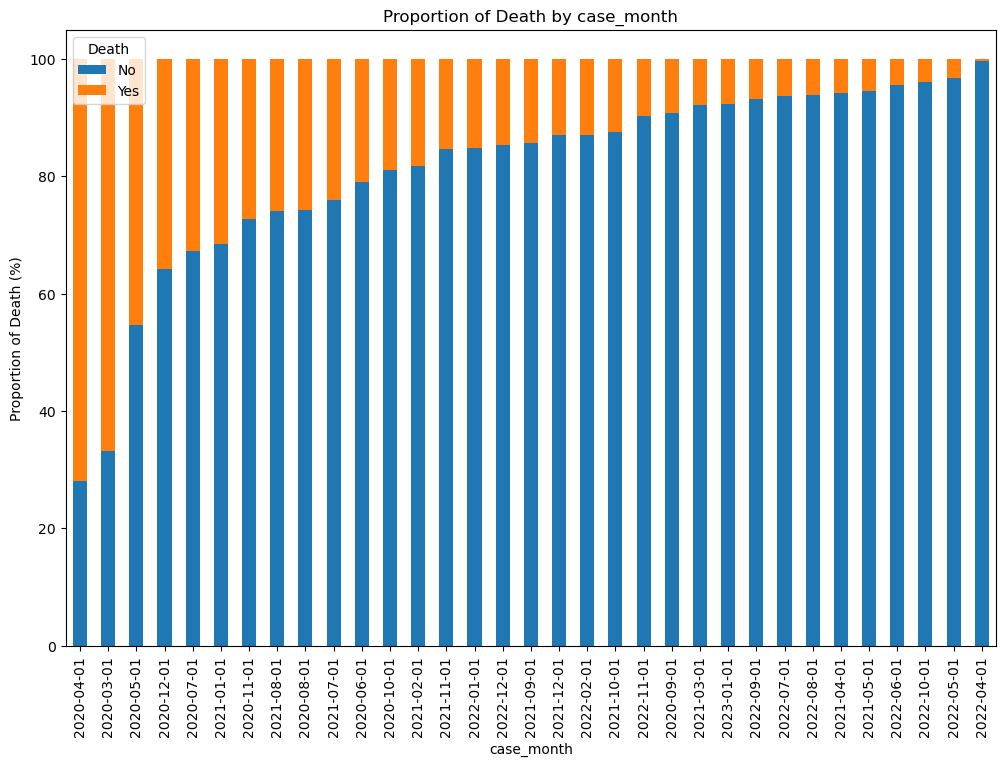

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


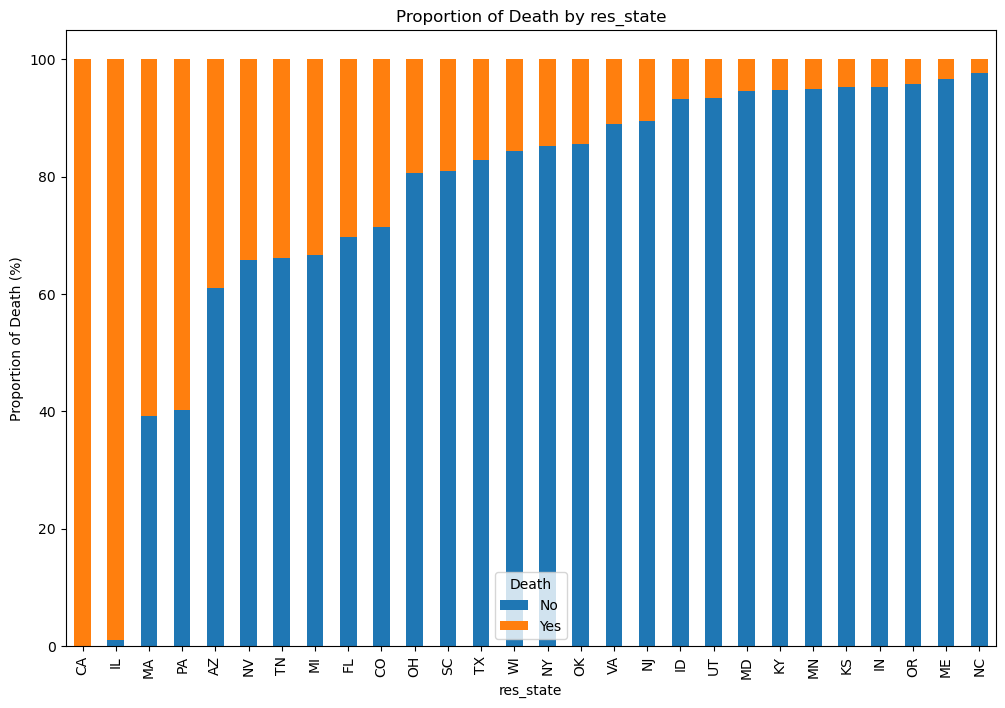

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


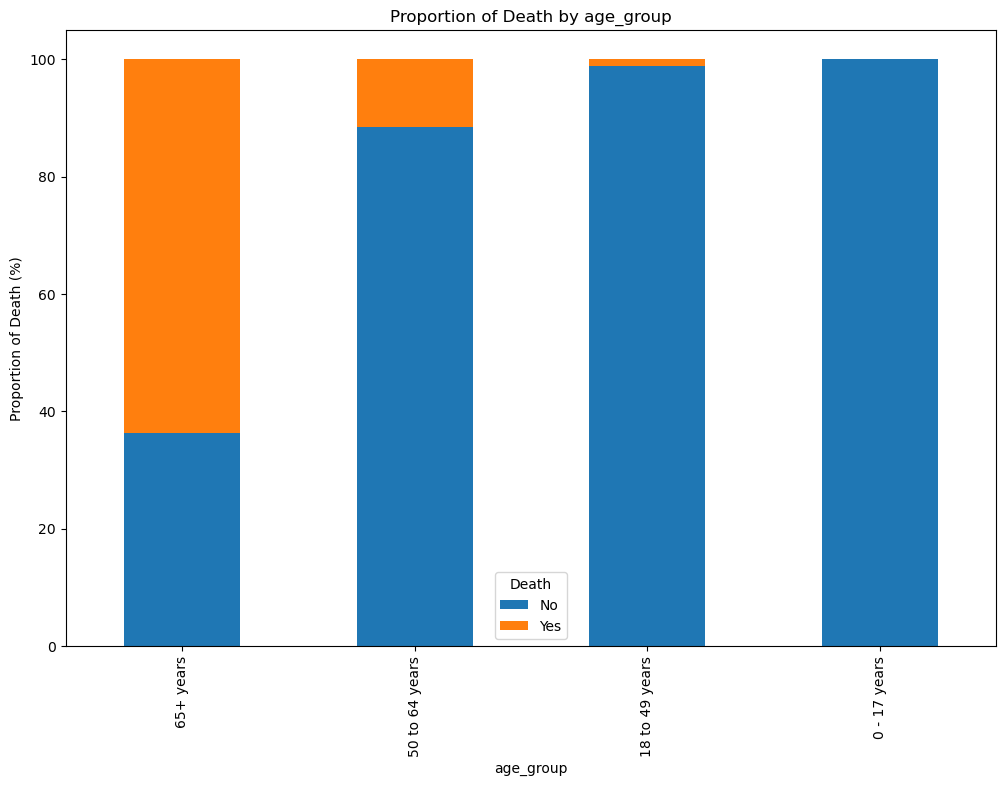

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


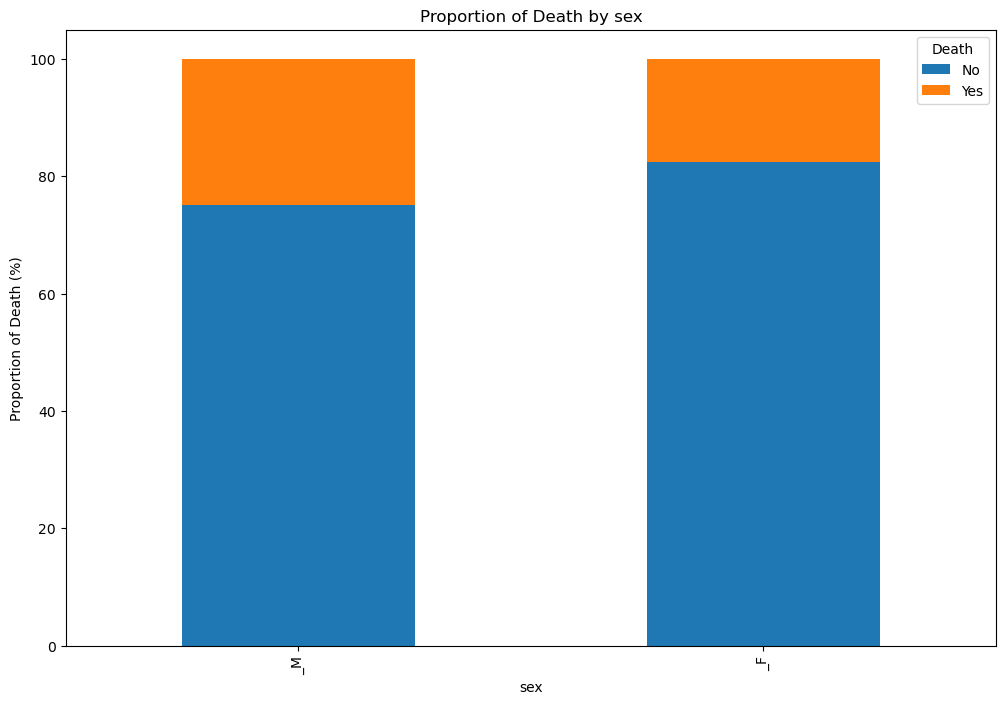

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


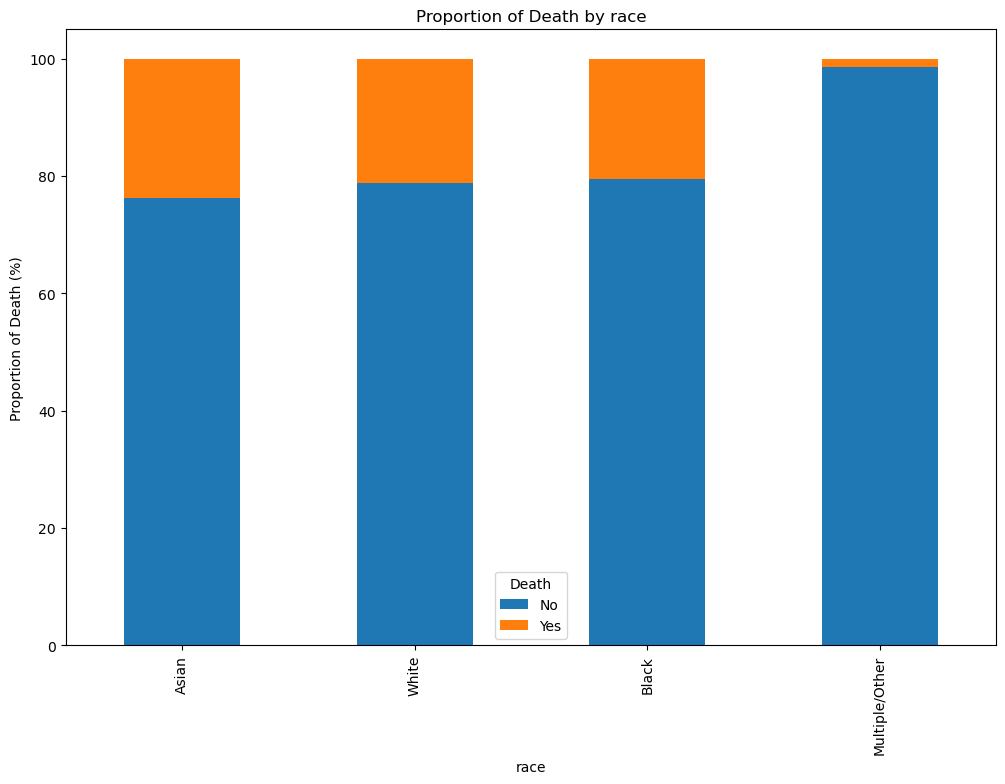

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


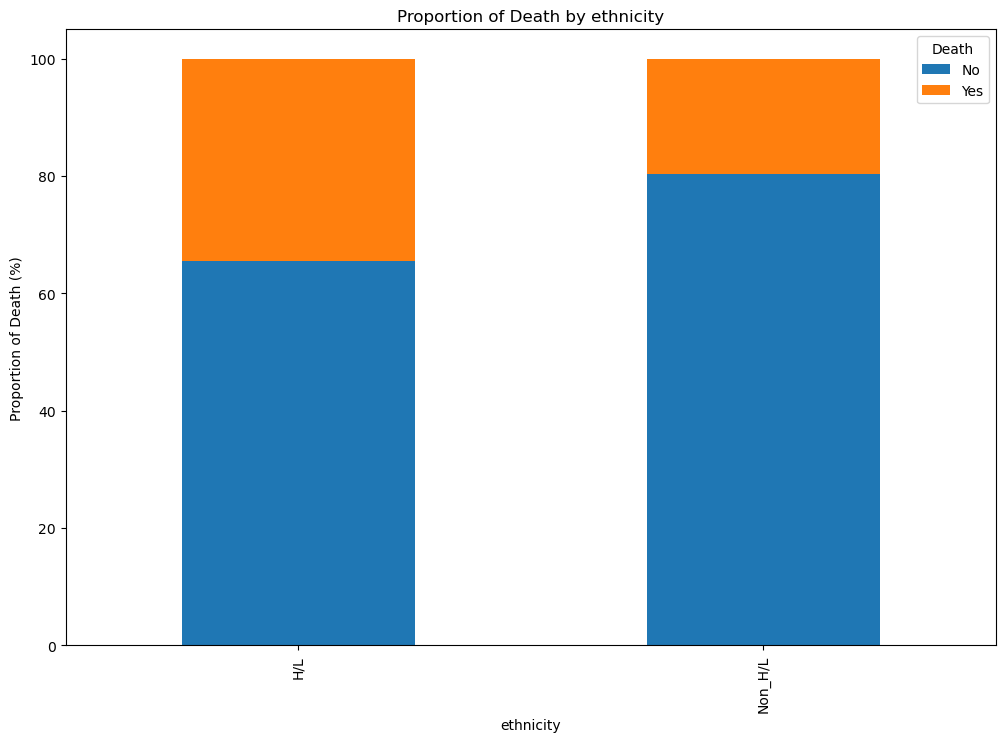

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


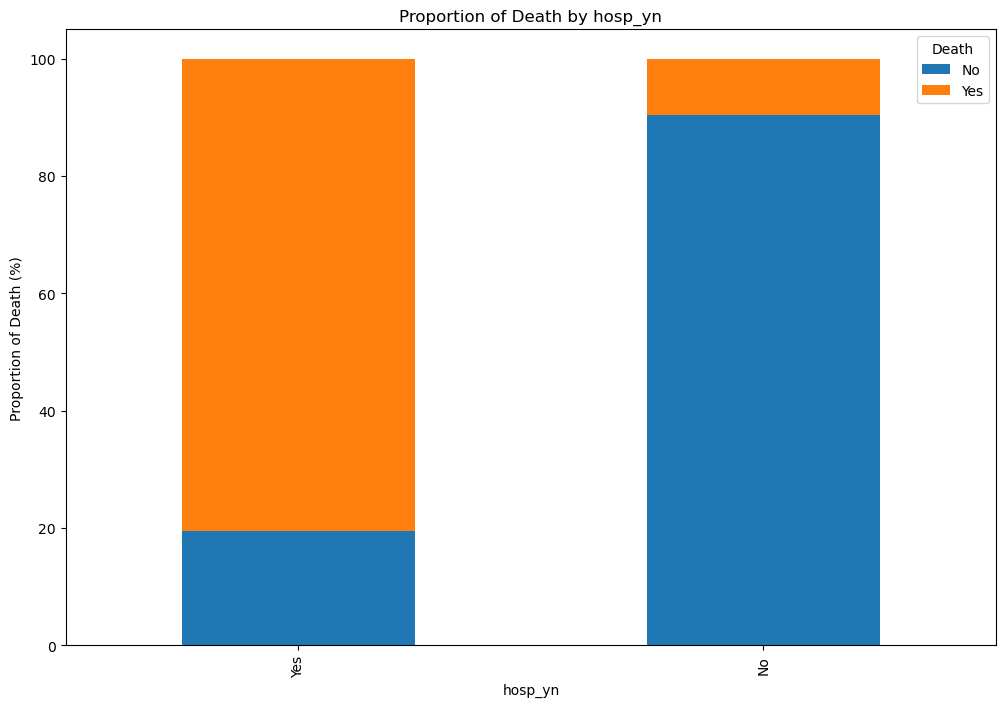

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


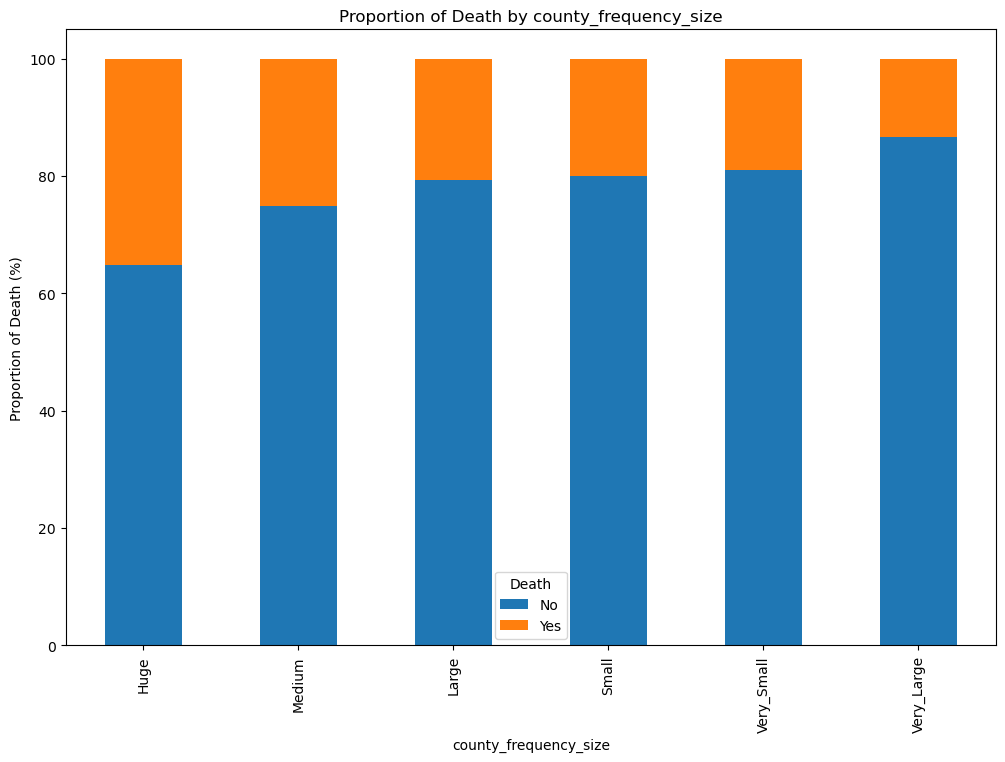

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


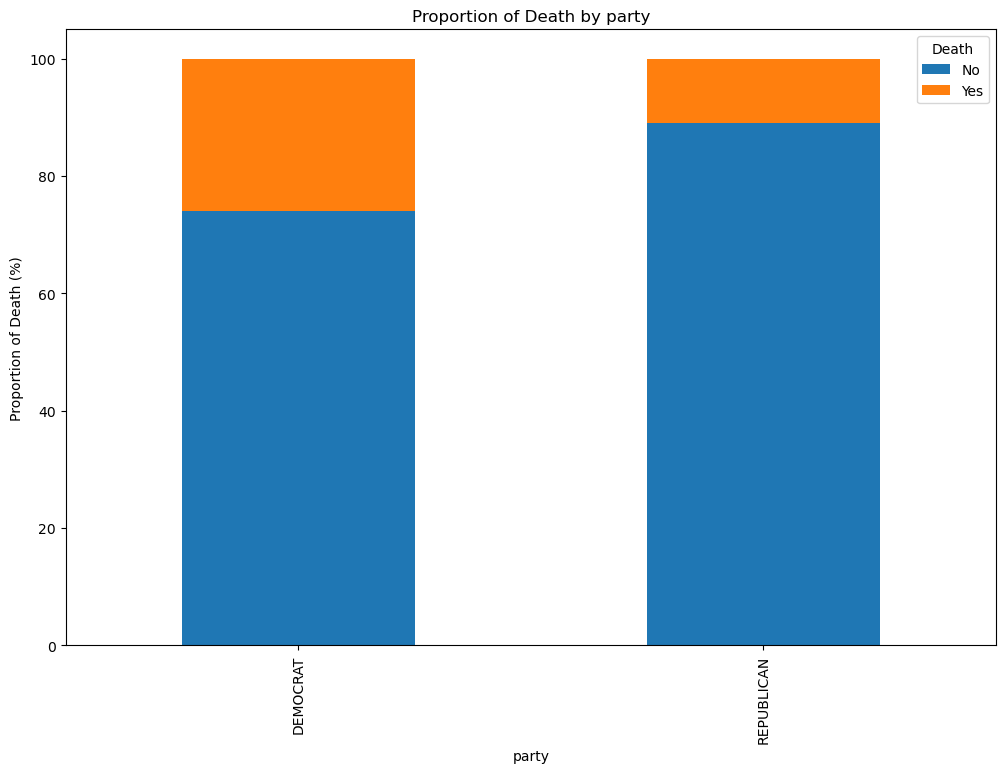

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


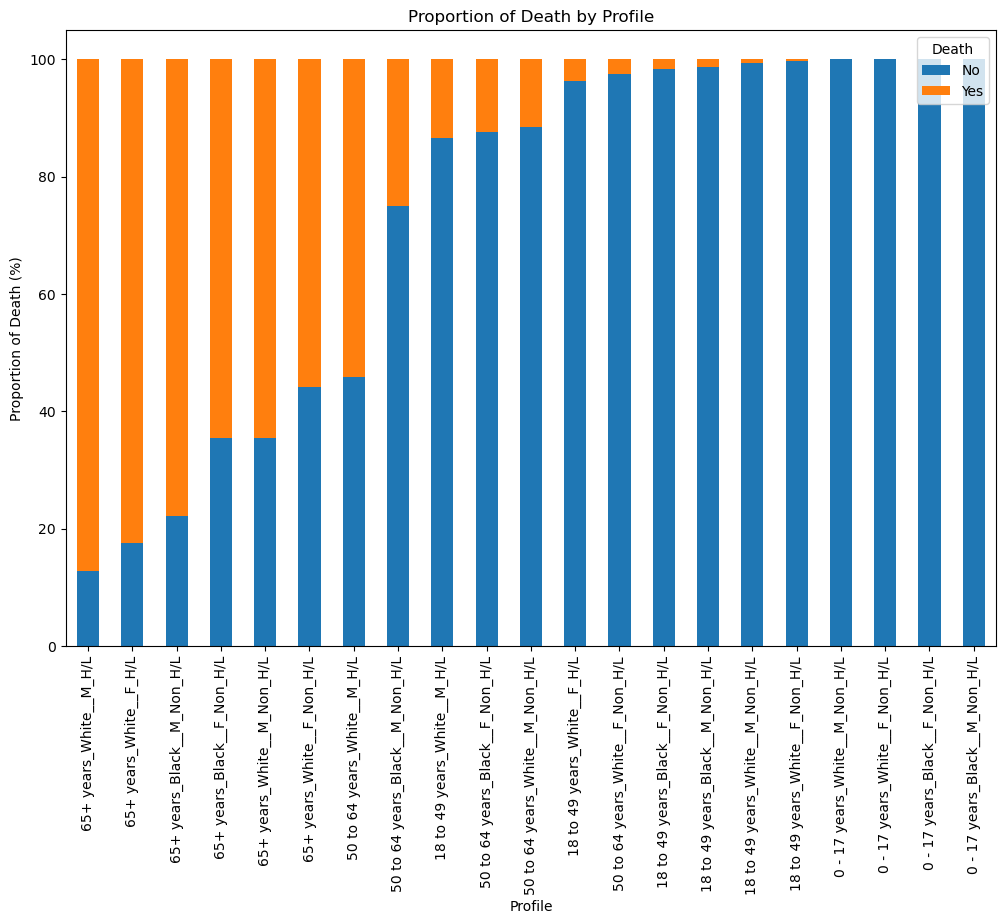

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\283739416.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


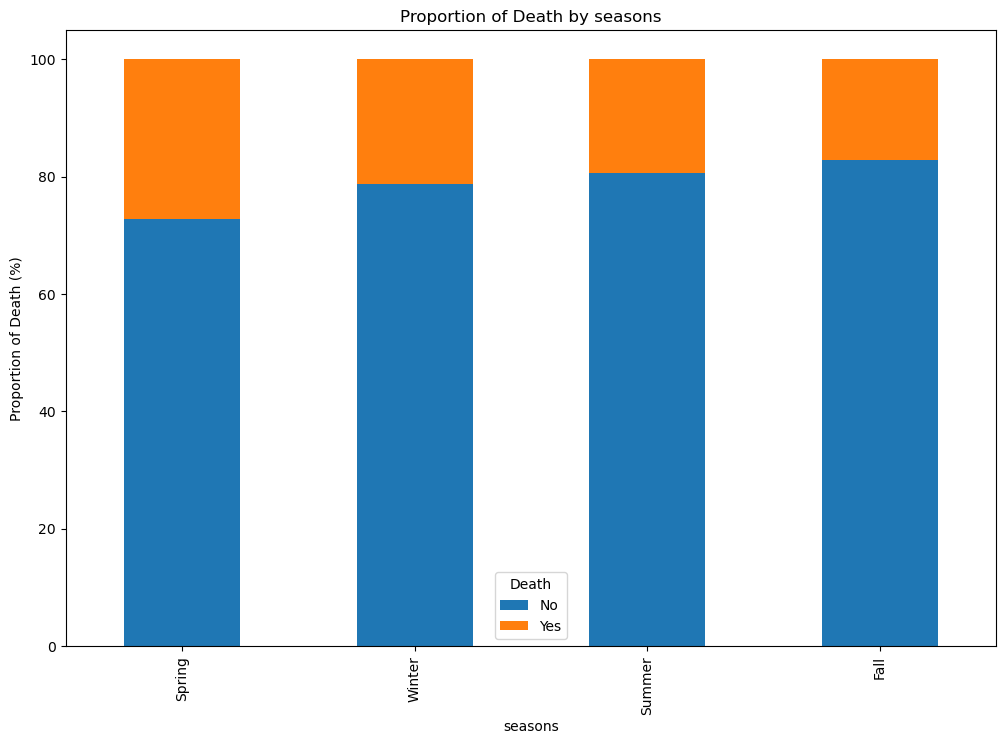

In [47]:
train_data = pd.concat([X_train, y_train], axis=1)


def plot_proportion_of_death(input, feature):
    # Calculate overall counts for each value in the feature
    overall_counts = input[feature].value_counts()

    # Filter features where overall count for any value is greater than 200: 0.5% of the overall dataset; allows for better graphing
    valid_features = overall_counts[overall_counts > 200].index.tolist()

    # Check if the feature has enough valid values
    if len(valid_features) == 0:
        print(f"No values in feature '{feature}' have overall count greater than 200.")
        return

    # Calculate counts of "Yes" and "No" for each feature
    death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)

    # Filter out only the valid values in the feature
    death_counts = death_counts.loc[valid_features]

    # Calculate proportion of death per feature category
    proportion_death_feature = death_counts.div(death_counts.sum(axis=1), axis=0) * 100

    # Sort based on highest death "Yes" proportion
    sorted_feature = proportion_death_feature.sort_values(by="Yes", ascending=False)

    sorted_feature.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.title(f"Proportion of Death by {feature}")
    plt.ylabel("Proportion of Death (%)")
    plt.xlabel(feature)
    plt.legend(title="Death")
    # plt.xticks(rotation=45)
    plt.show()

for column in X_train.columns:
    plot_proportion_of_death(train_data, column)

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


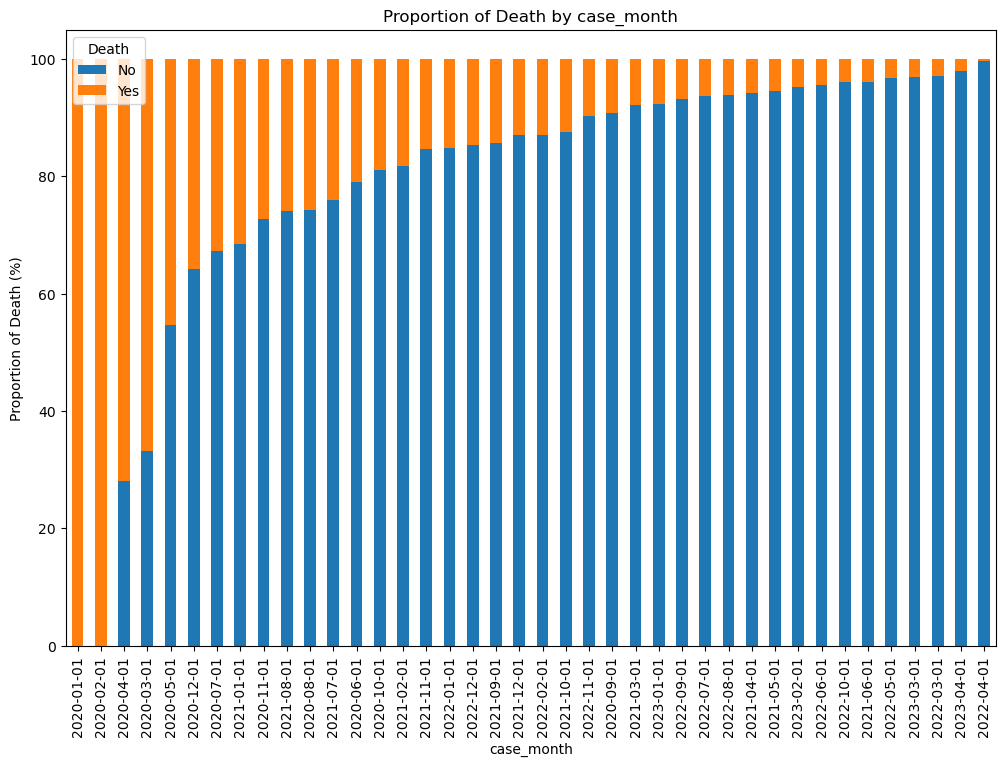

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


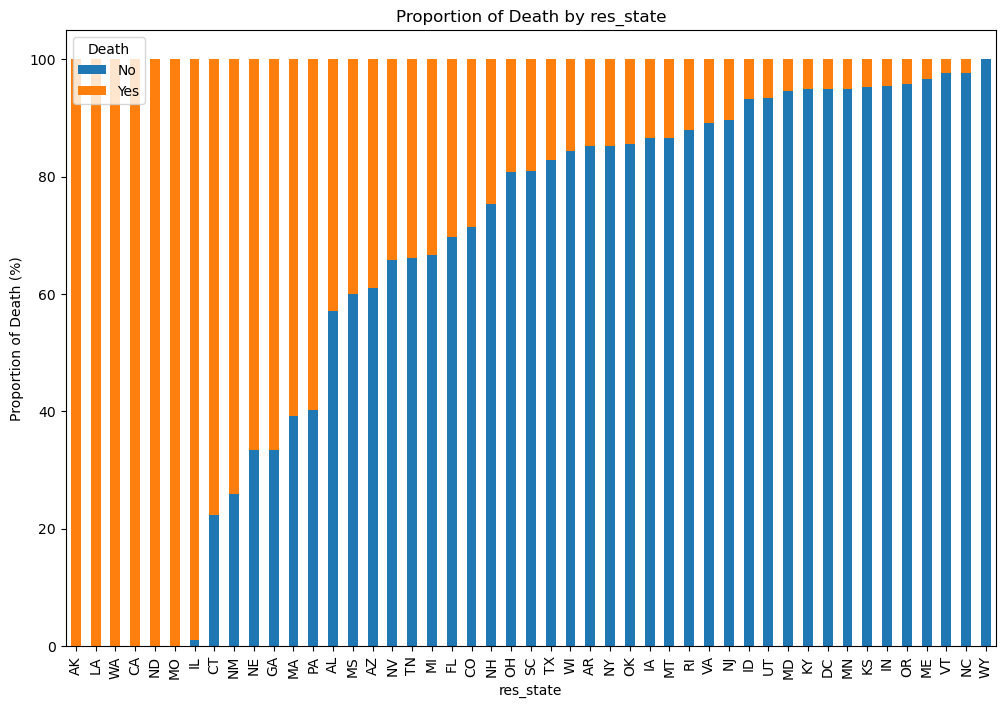

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


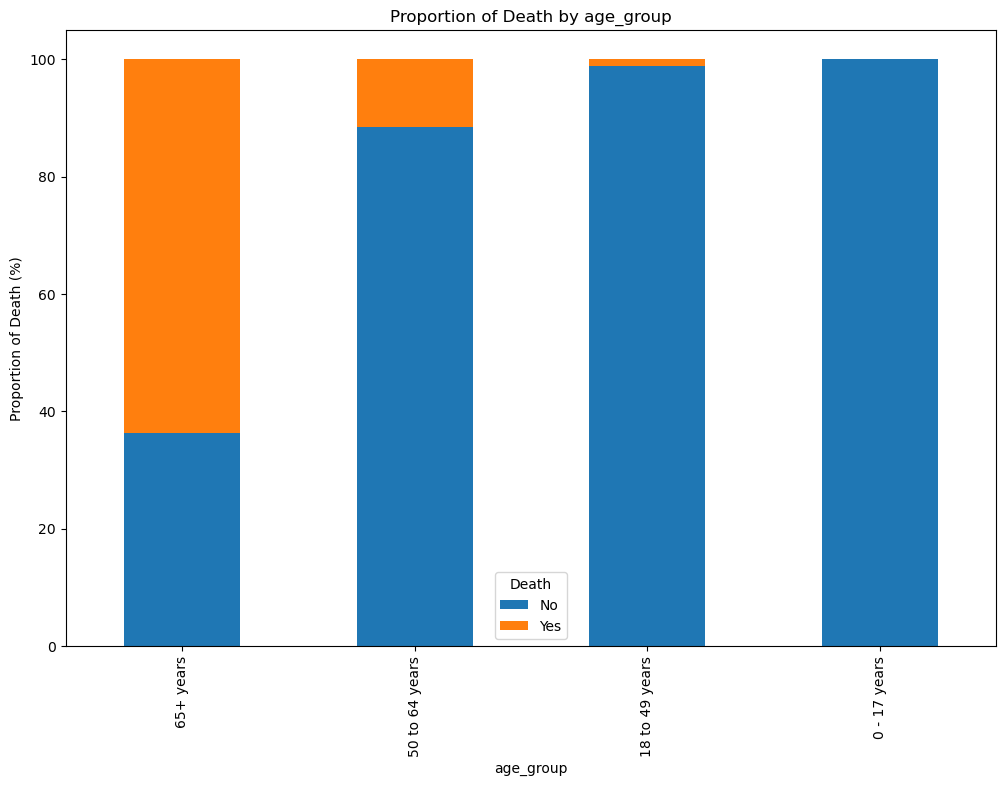

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


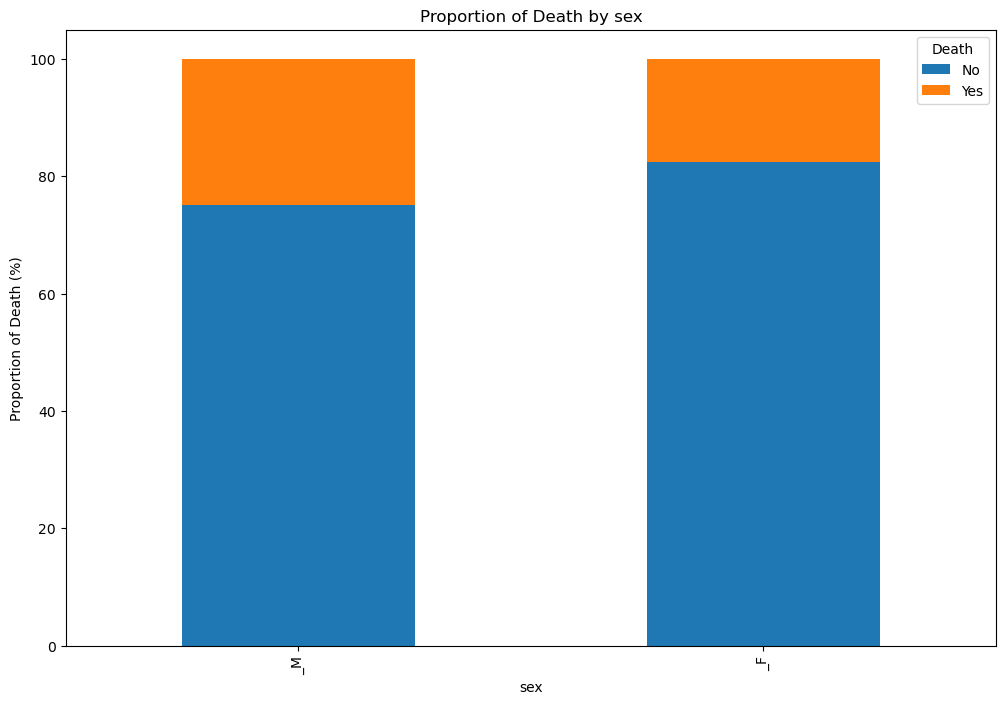

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


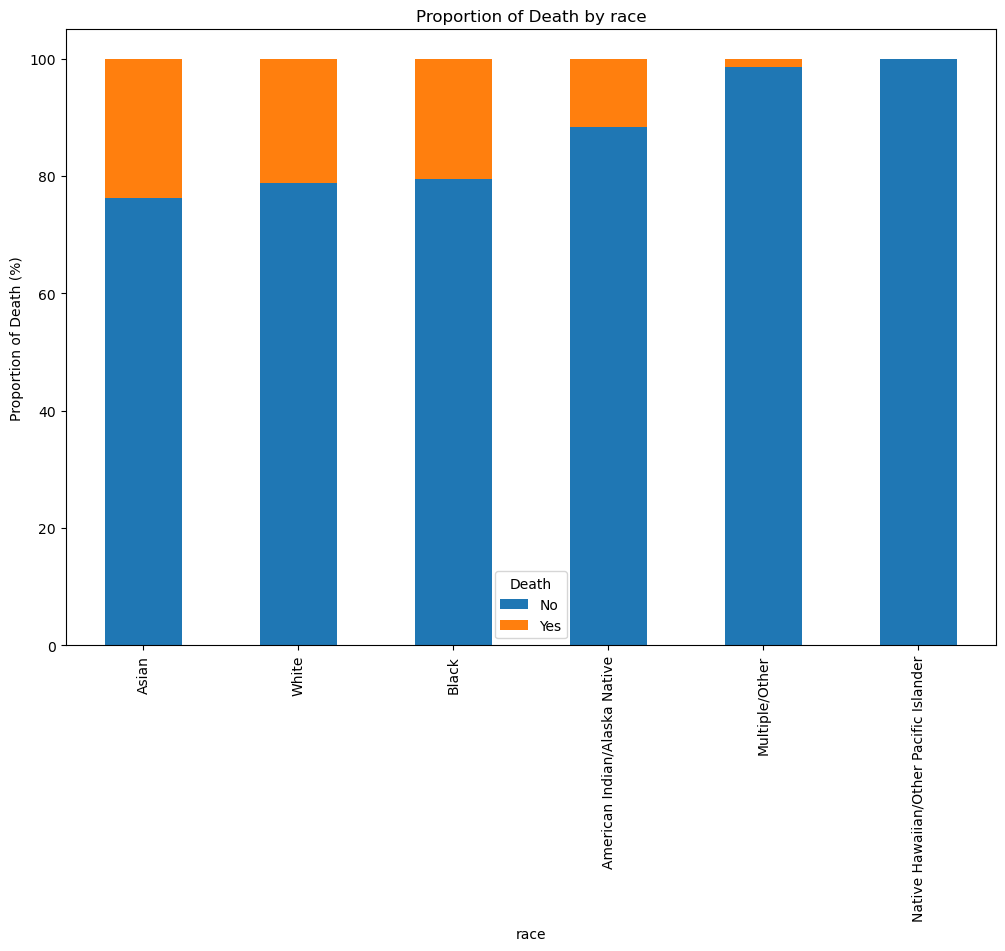

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


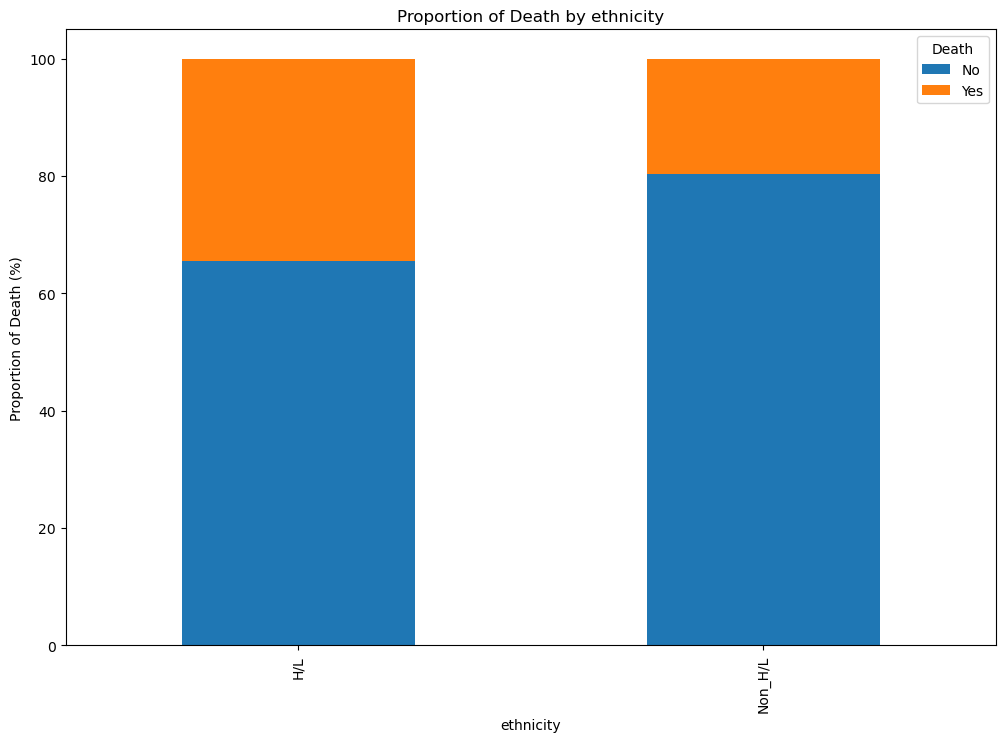

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


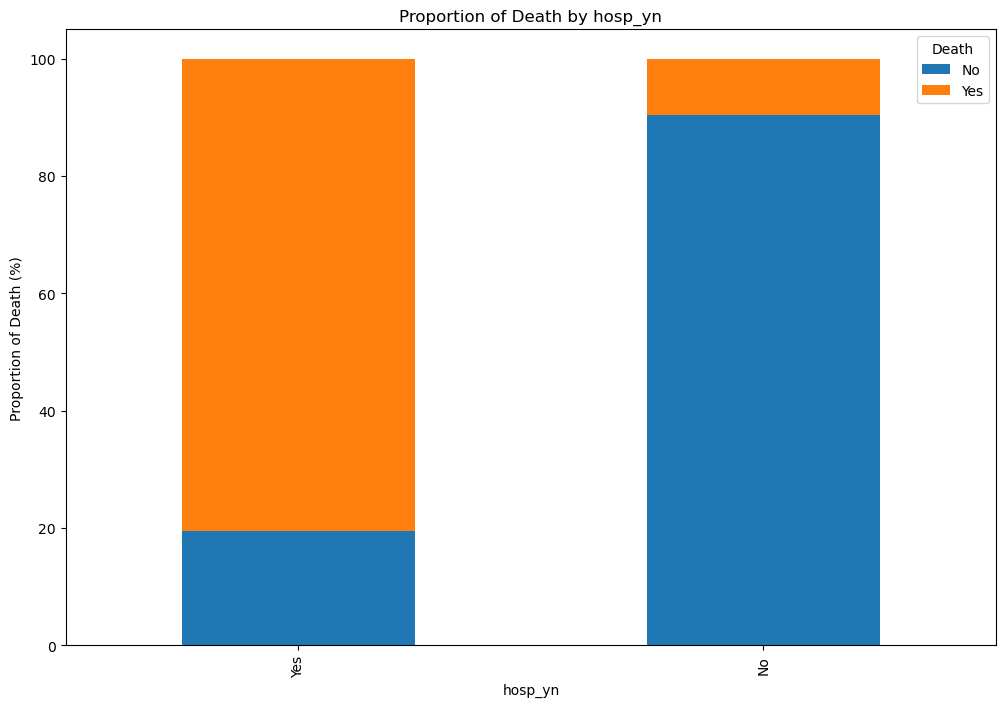

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


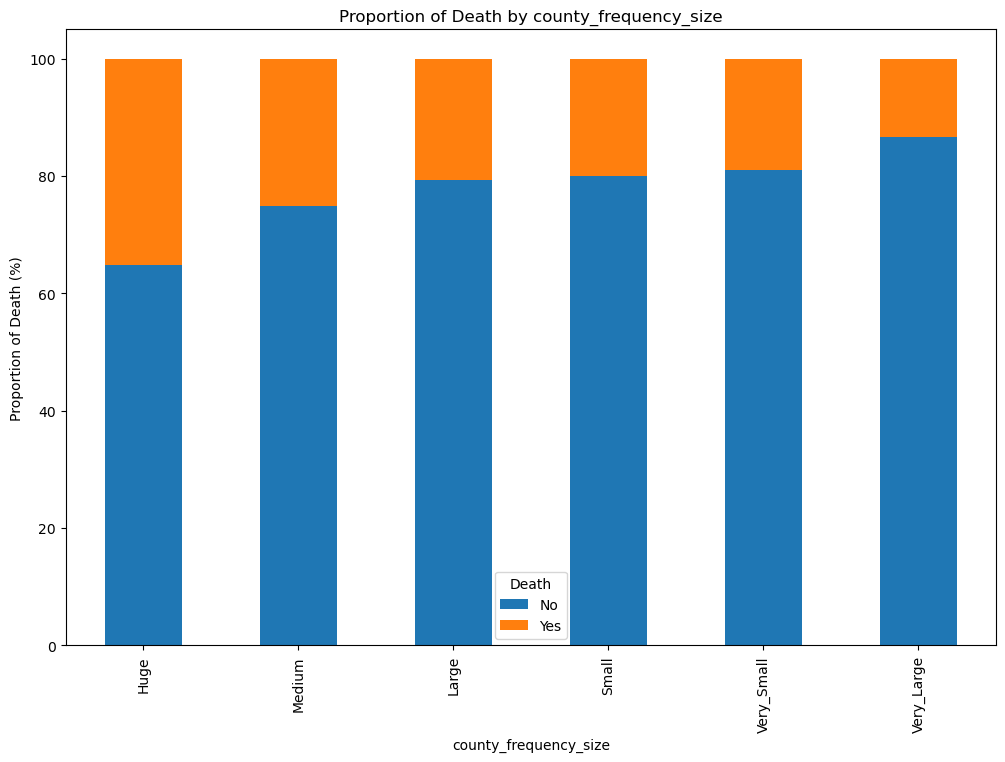

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


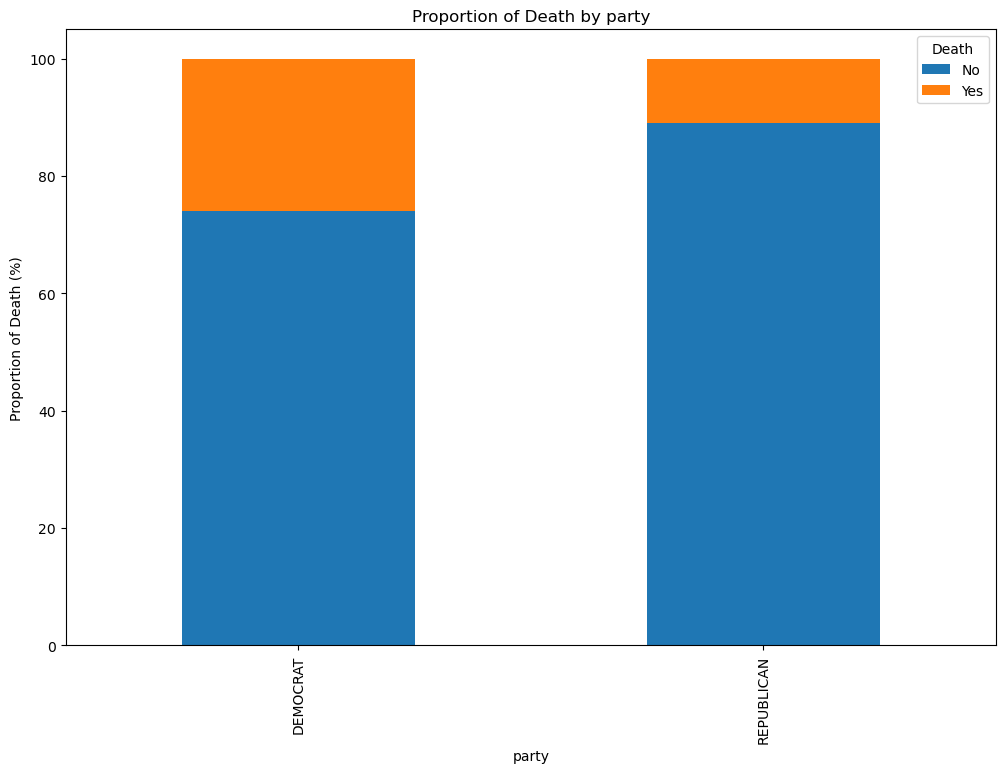

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


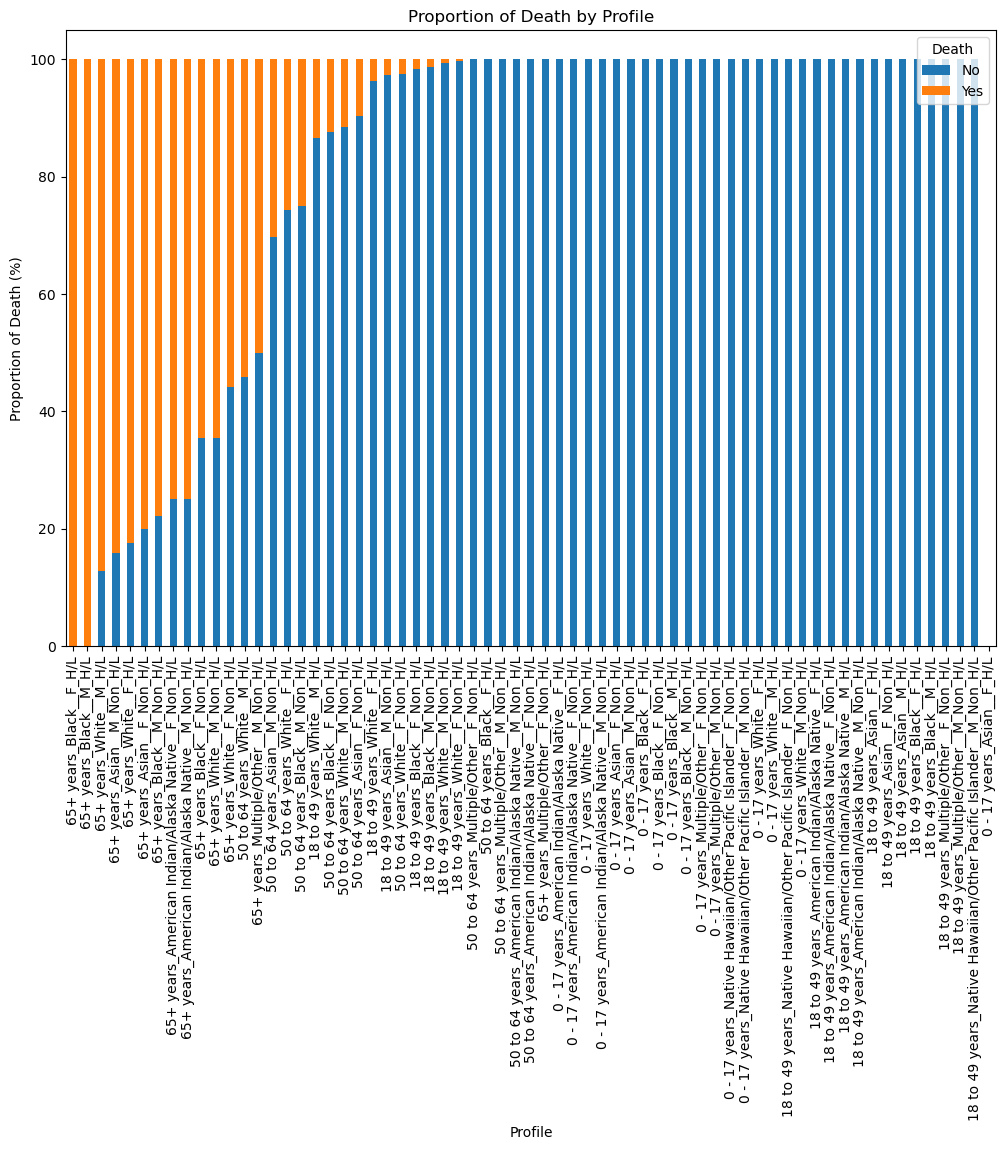

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3792341313.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


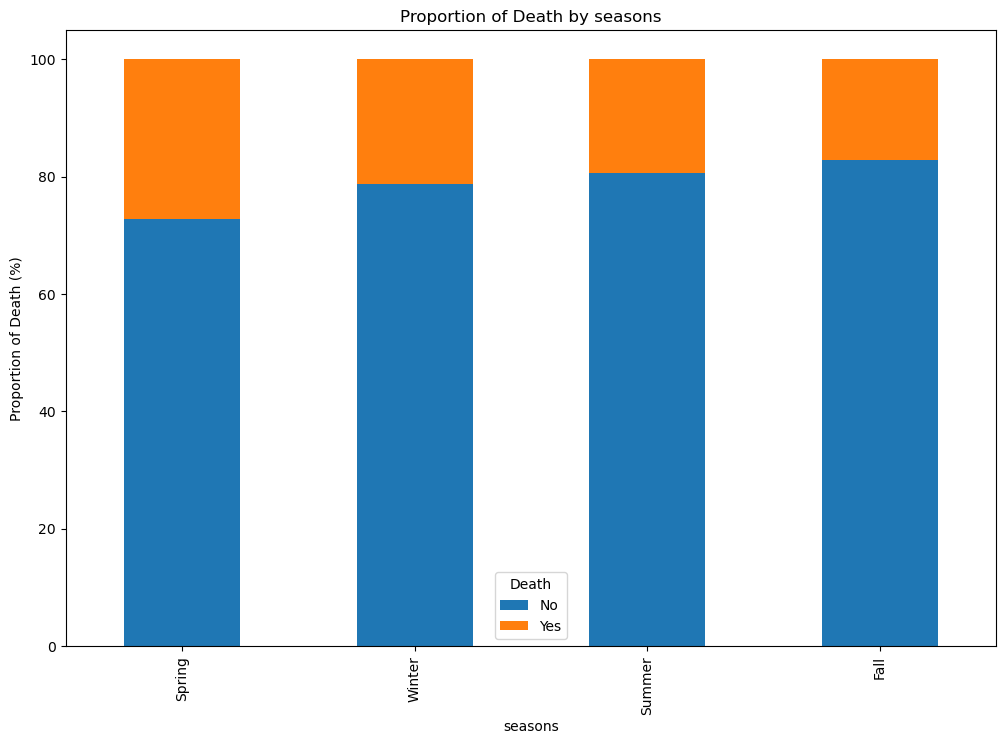

In [51]:
# train_data = pd.concat([X_train, y_train], axis=1)

# def plot_proportion_of_death(input, feature):
#     # Calculate counts of "Yes" and "No" for each feature
#     death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)

#     # Calculate proportion of death per feature category
#     proportion_death_feature = death_counts.div(death_counts.sum(axis=1), axis=0) * 100

#     # Sort based on highest death "Yes" proportion
#     sorted_feature = proportion_death_feature.sort_values(by="Yes", ascending=False)

#     sorted_feature.plot(kind="bar", stacked=True, figsize=(12, 8))
#     plt.title(f"Proportion of Death by {feature}")
#     plt.ylabel("Proportion of Death (%)")
#     plt.xlabel(feature)
#     plt.legend(title="Death")
#     plt.show()

# for column in X_train.columns:
#     plot_proportion_of_death(train_data, column)

 - **Discussion of subset of above pairwise interactions between plots:**
 - Knowledge gained
 - Which features seem to be better at predicting the target feature?

- The graphs above contain plots where values for the categories have a count of 200+. This is done in order to improve the legibility of the plots.
- In advance of the discussion that follows, it should be noted that there are 39,947 rows of data, and it seems likely that if statistical analyses such as t-tests or chi-squared are performed that p-values could be significant for each of the features in predicting death_yn.
- In addition to this, nationwide, the CDC database of the USA has 105,000,000 cases of Covid-19, and a death count of 1,143,724 as of late 2023 (https://www.cdc.gov/nchs/covid19/mortality-overview.htm). This means that Covid-19 has a rough mortality of 1.089% of those who contracted it, and this is a similar rate to that reported by the WHO (0.91%) (https://data.who.int/dashboards/covid19/cases?n=c). Given this data, features with frequencies which appear to be higher or lower than this rate could be good predictors for the target variable.
- 
- However, from the plots above age_group and hosp_yn show clear trends, and res_state shows a wide variance, and these seem promising for predicting death_yn.
- 
- **age_group**: The plotted pairwise interaction for age_group confirms suspicions that people 65+ years of age are most at risk of dying from Covid-19, and those aged 0-17 have what appears to be a near total survival rate. Additionally, the trend is present for all 4 values of age_group, 0-17 years, 18-49 years, 50-64 years, and 65+ years. The younger the person is, the more likely they are to survive, possibly due to the robustness of a child's immune system and conversely, older poeple are more susceptible to fatal illness.
- 
- **res_state**: This feature shows a wide degree of outcomes for the target variable. The graph shows 28 states, and there seems to be a roughly 95% variance for predicting the target outcome between the individual States. This appearance should not be chalked down to possible sampling issues, where states with small counts appear to have near 100% survival or fatality rates. On the contrary, the state with the highest death rate is the most populous, California, and the state with the highest survival rate is North Carolina, the 9th largest state in the USA.
- 
- **hosp_yn**: The stacked bar plot of hosp_yn appears to show the most variance and so could be a strong candidate for being able to predict death_yn. Importantly, this feature is a simple boolean, "Was Hospitalised" or "Was Not Hospitalised", and this has the advantages of reduced dimensionality and simplicity. The plot shows that people who were hospitalised are far more likely to pass away as a reuslt of contracting Covid-19. If a patient is hospitalised with Covid-19, their health status is likely to be worse and require treatment, whereas mostly unaffected people have no need of healthcare intervention.

    - (2.1) On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 

In [50]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

# Define column transformer to one-hot encode categorical variables
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 'hosp_yn', 'county_frequency_size', 'party', 'Profile', 'seasons'])],
    remainder='passthrough'
)

# Define the linear regression model
linear_reg_model = LinearRegression()

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('model', linear_reg_model)
])

# Train the model
pipeline.fit(X_train, y_train_encoded)

# Predict on the training set
y_train_pred = pipeline.predict(X_train)

# Model evaluation
mse_train = mean_squared_error(y_train_encoded, y_train_pred)
r2_train = r2_score(y_train_encoded, y_train_pred)

print("Training set evaluation:")
print("Mean Squared Error (MSE):", mse_train)
print("R-squared (R2) Score:", r2_train)


Training set evaluation:
Mean Squared Error (MSE): 0.052936933899495574
R-squared (R2) Score: 0.6805100816301406


integer encode months 
states = integer encode based off some value (size, region); maybe 1 hot encode
less than 8/ values for column = 1 hot encode

Google: why should i not 1 hot encoce? - if for overfitting, im fine

Do each of 3 models for 1 hot encoding, and for regionalising states etc..........

Issue with 1 hot encoding is overfitting, with this dataset that shouldnt be a problem

Target encoding === training data, what % of NY people survive, represent New York by that % - normalise data (between 0-1, standard normalisation = all variables have same effect)